В данном случае здесь применяются самые простые самописные трансформерами с механизмами attention и self-attention

In [ ]:
!pip install torchtext==0.11.0
!pip  install subword-nmt
!pip install wget

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import tqdm
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import pickle

In [ ]:
import sys
path_to_save_artifacts = '/content/drive/MyDrive/nlp_hw_2/self_attent/self_attent'
sys.path.append(path_to_save_artifacts)
from data_preparation import DataPreparation
import utils_for_atten
import self_atten_model

0.11.0


### Prepare data

In [ ]:
dataclass = DataPreparation()
train_data, valid_data, test_data = dataclass.data_pipeline()

download data
creating dataset
create train, valid and test data
Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
build vocab
Unique tokens in source (ru) vocabulary: 9247
Unique tokens in target (en) vocabulary: 6662


### Create model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
INPUT_DIM = len(dataclass.SRC.vocab)
OUTPUT_DIM = len(dataclass.TRG.vocab)
TRG_PAD_IDX = dataclass.TRG.vocab.stoi[dataclass.TRG.pad_token]
SRC_PAD_IDX = dataclass.SRC.vocab.stoi[dataclass.SRC.pad_token]

model = self_atten_model.prepare_model(device, INPUT_DIM, OUTPUT_DIM, SRC_PAD_IDX, TRG_PAD_IDX)

In [ ]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
TRG_PAD_IDX = dataclass.TRG.vocab.stoi[dataclass.TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Train model

In [ ]:
N_EPOCHS = 20
CLIP = 1
train_history = []
valid_history = []
bleu_history = []

best_valid_loss = float('inf')


for epoch in range(N_EPOCHS):
    
    train_loss = utils_for_atten.train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss, bleu = utils_for_atten.evaluate(model, valid_iterator, criterion, dataclass.TRG.vocab)    
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    bleu_history.append(bleu)
    history_dict = {'bleu': bleu_history, 'train': train_history, 'valid': valid_history}
    with open( path_to_save_artifacts + '/model_results.pkl', 'wb') as f:
      pickle.dump(history_dict, f)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_to_save_artifacts + '/self_atten.pt') 
    print(f'epoch: {epoch}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | lr: {optimizer.param_groups[0]["lr"]}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | val. bleu: {bleu}')
    if epoch!=0:
      if epoch % 5 == 0:
        scheduler.step()
      else:
        pass

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0
	Train Loss: 3.369 | Train PPL:  29.052 | lr: 0.001
	 Val. Loss: 2.210 |  Val. PPL:   9.116 | val. bleu: 22.09887810687072


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1
	Train Loss: 2.289 | Train PPL:   9.866 | lr: 0.001
	 Val. Loss: 1.872 |  Val. PPL:   6.502 | val. bleu: 29.06678012704425


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 2
	Train Loss: 1.946 | Train PPL:   7.002 | lr: 0.001
	 Val. Loss: 1.709 |  Val. PPL:   5.526 | val. bleu: 32.533987059361806


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 3
	Train Loss: 1.727 | Train PPL:   5.622 | lr: 0.001
	 Val. Loss: 1.624 |  Val. PPL:   5.074 | val. bleu: 34.440545127013415


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 4
	Train Loss: 1.564 | Train PPL:   4.779 | lr: 0.001
	 Val. Loss: 1.600 |  Val. PPL:   4.953 | val. bleu: 35.25992538804498


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 5
	Train Loss: 1.443 | Train PPL:   4.234 | lr: 0.001
	 Val. Loss: 1.568 |  Val. PPL:   4.796 | val. bleu: 36.462488089055064


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 6
	Train Loss: 1.218 | Train PPL:   3.382 | lr: 0.0001
	 Val. Loss: 1.504 |  Val. PPL:   4.501 | val. bleu: 38.22593691160415


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 7
	Train Loss: 1.163 | Train PPL:   3.198 | lr: 0.0001
	 Val. Loss: 1.498 |  Val. PPL:   4.474 | val. bleu: 38.99045370571111


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 8
	Train Loss: 1.130 | Train PPL:   3.096 | lr: 0.0001
	 Val. Loss: 1.495 |  Val. PPL:   4.461 | val. bleu: 39.19327271909479


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 9
	Train Loss: 1.105 | Train PPL:   3.020 | lr: 0.0001
	 Val. Loss: 1.495 |  Val. PPL:   4.460 | val. bleu: 39.179438753755406


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 10
	Train Loss: 1.084 | Train PPL:   2.957 | lr: 0.0001
	 Val. Loss: 1.495 |  Val. PPL:   4.458 | val. bleu: 39.527970916047046


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 11
	Train Loss: 1.055 | Train PPL:   2.872 | lr: 1e-05
	 Val. Loss: 1.492 |  Val. PPL:   4.448 | val. bleu: 39.86489233293639


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 12
	Train Loss: 1.052 | Train PPL:   2.863 | lr: 1e-05
	 Val. Loss: 1.492 |  Val. PPL:   4.447 | val. bleu: 39.81701032111823


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 13
	Train Loss: 1.049 | Train PPL:   2.855 | lr: 1e-05
	 Val. Loss: 1.493 |  Val. PPL:   4.449 | val. bleu: 39.821612659327805


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 14
	Train Loss: 1.047 | Train PPL:   2.850 | lr: 1e-05
	 Val. Loss: 1.493 |  Val. PPL:   4.450 | val. bleu: 39.723209281292206


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 15
	Train Loss: 1.044 | Train PPL:   2.841 | lr: 1e-05
	 Val. Loss: 1.493 |  Val. PPL:   4.451 | val. bleu: 39.711964087447605


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 16
	Train Loss: 1.040 | Train PPL:   2.829 | lr: 1.0000000000000002e-06
	 Val. Loss: 1.493 |  Val. PPL:   4.449 | val. bleu: 39.75527277746093


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 17
	Train Loss: 1.040 | Train PPL:   2.828 | lr: 1.0000000000000002e-06
	 Val. Loss: 1.493 |  Val. PPL:   4.448 | val. bleu: 39.75326908704278


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 18
	Train Loss: 1.039 | Train PPL:   2.828 | lr: 1.0000000000000002e-06
	 Val. Loss: 1.492 |  Val. PPL:   4.448 | val. bleu: 39.768438534815594


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 19
	Train Loss: 1.039 | Train PPL:   2.826 | lr: 1.0000000000000002e-06
	 Val. Loss: 1.493 |  Val. PPL:   4.449 | val. bleu: 39.73708296683851


### Load best model

In [ ]:
best_model = self_atten_model.prepare_model(device, INPUT_DIM, OUTPUT_DIM, SRC_PAD_IDX, TRG_PAD_IDX)
best_model.load_state_dict(torch.load(path_to_save_artifacts + '/self_atten.pt'))
best_model.eval()

## Check quality of network

In [ ]:
losses, originals, generated_text = utils_for_atten.bad_and_good_translations(best_model, test_iterator, criterion, dataclass.TRG.vocab)

  0%|          | 0/59 [00:00<?, ?it/s]

Best translations

In [ ]:
idx_of_good = np.argsort(losses)
print('Good translation:')
for i in range(3):
  print('Original: {}'.format(' '.join(originals[idx_of_good[i]])))
  print('Generated: {}'.format(' '.join(generated_text[idx_of_good[i]])))

Good translation:
Original: bed linen is available .
Generated: bed linen is provided .
Original: guests can enjoy the on - site restaurant .
Generated: guests can enjoy the on - site restaurant .
Original: free wifi access is available .
Generated: free wifi access is available .


Worst translations

In [ ]:
idx_of_bad = np.argsort(losses)[::-1]
print('Bad translation:')
for i in range(54,56):
  print('Original: {}'.format(' '.join(originals[idx_of_bad[i]])))
  print('Generated: {}'.format(' '.join(generated_text[idx_of_bad[i]])))

Bad translation:
Original: a hairdryer can be found in the bathroom .
Generated: the hairdryer is be found in the bathroom .
Original: free parking facilities are offered to guests who drive .
Generated: the parking is are available . the . drive .


check metricks

In [ ]:
loss, bleu = utils_for_atten.evaluate(model, train_iterator, criterion, dataclass.TRG.vocab)
print(f'\t train. Loss: {loss:.3f} |  train. PPL: {math.exp(loss):7.3f} | train. bleu: {bleu}')
loss, bleu = utils_for_atten.evaluate(model, test_iterator, criterion, dataclass.TRG.vocab) 
print(f'\t test. Loss: {loss:.3f} |  test. PPL: {math.exp(loss):7.3f} | test. bleu: {bleu}')
loss, bleu = utils_for_atten.evaluate(model, valid_iterator, criterion, dataclass.TRG.vocab) 
print(f'\t Val. Loss: {loss:.3f} |  Val. PPL: {math.exp(loss):7.3f} | val. bleu: {bleu}')

  0%|          | 0/313 [00:00<?, ?it/s]

	 train. Loss: 0.827 |  train. PPL:   2.286 | train. bleu: 52.84911249389314


  0%|          | 0/59 [00:00<?, ?it/s]

	 test. Loss: 1.495 |  test. PPL:   4.459 | test. bleu: 39.28017102273063


  0%|          | 0/20 [00:00<?, ?it/s]

	 Val. Loss: 1.493 |  Val. PPL:   4.449 | val. bleu: 39.73708296683851


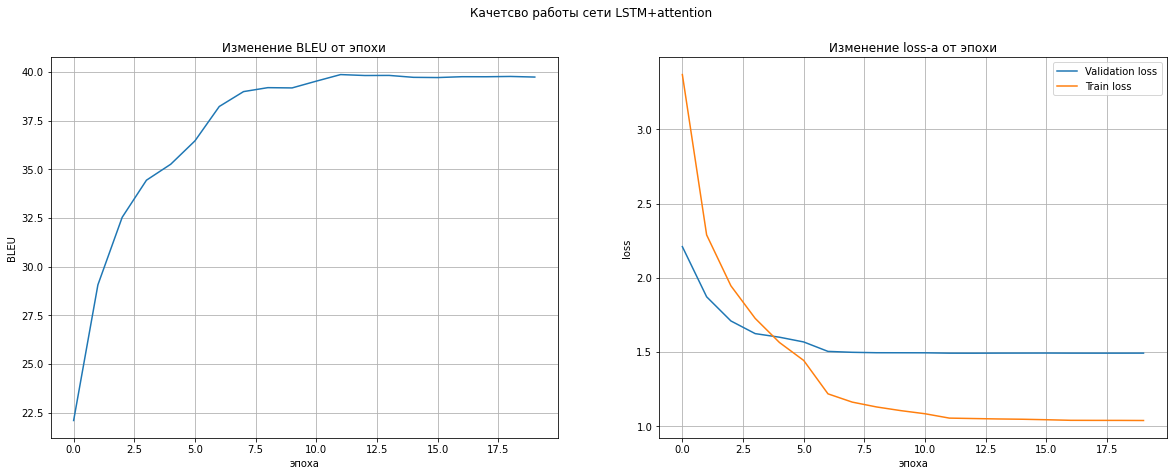

In [ ]:
with open(path_to_save_artifacts + '/model_results.pkl', 'rb') as f:
    history_dict = pickle.load(f)
bleu = history_dict['bleu']
train_losses = history_dict['train']
valid_losses = history_dict['valid']
fig, axs = plt.subplots(1,2, figsize = (20,7))
fig.suptitle('Качетсво работы сети LSTM+attention')
axs[0].set_title('Изменение BLEU от эпохи')
axs[0].set_xlabel('эпоха')
axs[0].set_ylabel('BLEU')
axs[0].grid()
axs[0].plot(range(len(bleu)), bleu)

axs[1].set_title('Изменение loss-a от эпохи')
axs[1].set_xlabel('эпоха')
axs[1].set_ylabel('loss')
axs[1].grid()
axs[1].plot(range(len(valid_losses)), valid_losses, label = 'Validation loss')
axs[1].plot(range(len(train_losses)), train_losses, label = 'Train loss')
axs[1].legend()
plt.show();

# Краткий обзор

Здесь решил рассмотреть рассмотреть механизм self-attention, который используют в трансформерах. Процесс обучения такой же как и в других моделях.

### Метрики: 
train. Loss: 0.827 |  train. PPL:   2.286 | train. bleu: 52.84911249389314

test. Loss: 1.495 |  test. PPL:   4.459 | test. bleu: 39.28017102273063

Val. Loss: 1.493 |  Val. PPL:   4.449 | val. bleu: 39.73708296683851
### Хорошие и плохие переводы преставлены выше.
### Графики обучения также предствалены выше.
### Скорость обучения:
30 секунд на эпоху, где батч = 128, а треин корпус состоит из 40000 примеров,
что очень быстро, по сравнению с остальными сетями
### Cкорость инференса:

CPU times: user 18 ms, sys: 0 ns, total: 18 ms
Wall time: 18.5 ms

На батч из 32

что намного быстрее других самописных сетей